In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import itertools
from collections import Counter
from sklearn import metrics
import keras
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Activation
from keras.optimizers import Adam
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

### Load Data

In [2]:
# Load oversampled X
oversampled_X_train = np.load('../Data/oversampled_X_train.npy')
# Load oversampled y
oversampled_y_train = np.load('../Data/overssampled_y_train.npy')
# load test set
norm_test = np.load('../Data/norm_test.npy')
y_test = np.load('../Data/y_test.npy')

In [3]:
train_label = oversampled_y_train >0
test_label = y_test>0

### Classfication

#### Let's first create a model for the oversampled data

In [12]:
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(250, input_dim=oversampled_X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(150, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(28, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                  factor=0.2, 
                  patience=5,   
                  epsilon=0.0001,  
                  min_lr=0)
modelchecker = ModelCheckpoint('mlp_classification_oversample.h5', save_best_only=True)

# earlystopper = EarlyStopping(patience=20, mode='min')

In [ ]:
batch_size = 400
epochs = 30
model = create_baseline()

history = model.fit(oversampled_X_train, train_label,
                    validation_data=(norm_test, test_label),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[reduce_lr, modelchecker])

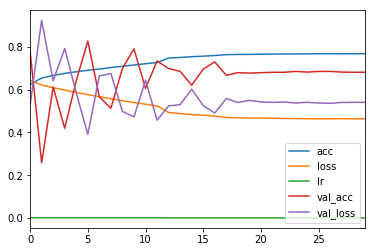

In [69]:
pd.DataFrame(history.history).plot();

#### Now create one for smote data

In [93]:
final_train = np.load('../Data/smoted_train_X_and_y.npy')
smote_xtrain = final_train[:, :-1]
smote_ytrain = final_train[:, -1]
smote_train_label = smote_ytrain>0
smote_train_label = smote_train_label.astype(np.bool)

dim_reduced_data_test = np.load('../Data/autoencoded_data_test.npy')

In [51]:
def create_baseline_for_smoteData():
    # create model
    model = Sequential()
    model.add(Dense(40, input_dim=smote_xtrain.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(40, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(40, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(40, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

In [52]:
reduce_lr2 = ReduceLROnPlateau(monitor='val_loss', 
                  factor=0.2, 
                  patience=5,   
                  epsilon=0.0001,  
                  min_lr=0)
modelchecker2 = ModelCheckpoint('mlp_classification_smote.h5', save_best_only=True)

In [53]:
batch_size = 400
epochs = 60
model2 = create_baseline_for_smoteData()

history2 = model2.fit(smote_xtrain, smote_train_label,
                    validation_data=(dim_reduced_data_test, test_label),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[reduce_lr2, modelchecker2])

Train on 320028 samples, validate on 42266 samples
Epoch 1/60
320028/320028 [==============================] - 6s - loss: 0.6808 - acc: 0.5509 - val_loss: 0.6575 - val_acc: 0.4757
Epoch 2/60
320028/320028 [==============================] - 5s - loss: 0.6636 - acc: 0.5941 - val_loss: 0.8048 - val_acc: 0.2030
Epoch 3/60
320028/320028 [==============================] - 5s - loss: 0.6597 - acc: 0.6013 - val_loss: 0.5924 - val_acc: 0.6336
Epoch 4/60
320028/320028 [==============================] - 5s - loss: 0.6579 - acc: 0.6042 - val_loss: 0.7499 - val_acc: 0.3797
Epoch 5/60
320028/320028 [==============================] - 5s - loss: 0.6558 - acc: 0.6076 - val_loss: 0.6389 - val_acc: 0.6067
Epoch 6/60
320028/320028 [==============================] - 5s - loss: 0.6538 - acc: 0.6111 - val_loss: 0.5310 - val_acc: 0.7091
Epoch 7/60
320028/320028 [==============================] - 5s - loss: 0.6509 - acc: 0.6153 - val_loss: 0.6236 - val_acc: 0.5903
Epoch 8/60
320028/320028 [====================

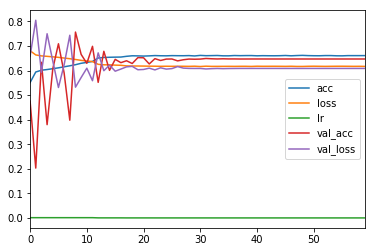

In [55]:
pd.DataFrame(history2.history).plot();

### Compare the the result on test set

In [10]:
mlp_classification_oversample = keras.models.load_model('../02__Classification/mlp_classification_oversample.h5')

In [12]:
mlp_classficaition_smote = keras.models.load_model('../02__Classification/mlp_classification_smote.h5')

In [15]:
def predict_score_class_accuracy(model, X, y):
    y_score = model.predict_proba(X)
    pred_class = model.predict_classes(X)
    accuracy = model.evaluate(X, y)
    return y_score, pred_class, accuracy

In [94]:
os_score, os_class, os_accuracy = predict_score_class_accuracy(mlp_classification_oversample, norm_test, test_label)
smote_score, smote_class, smote_accuracy = predict_score_class_accuracy(mlp_classficaition_smote, dim_reduced_data_test, test_label)

41440/42266 [============================>.] - ETA: 0s

In [95]:
print('class_accuracy for OS: ', np.around(os_accuracy, 4))
print('class_accuracy for SMOTE: ', np.around(smote_accuracy,4))

class_accuracy for OS:  [ 0.3911  0.8276]
class_accuracy for SMOTE:  [ 0.531   0.7091]


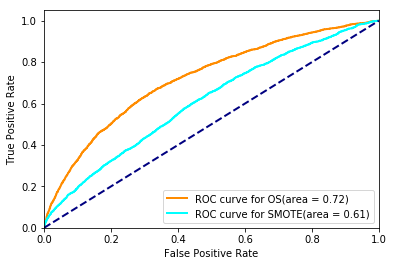

In [96]:
fpr, tpr, _ = metrics.roc_curve(test_label, os_score)
fpr2, tpr2, _ = metrics.roc_curve(test_label, smote_score)
roc_auc = metrics.auc(fpr,tpr)
roc_auc2 = metrics.auc(fpr2,tpr2)
plt.plot(fpr, tpr, lw=2, color='darkorange', label='ROC curve for OS(area = %0.2f)' % roc_auc)
plt.plot(fpr2, tpr2, lw=2, color='aqua', label='ROC curve for SMOTE(area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [97]:
precision, recall, f1_score,_ = metrics.precision_recall_fscore_support(test_label, os_class, average='binary')
precision2, recall2, f1_score2,_ = metrics.precision_recall_fscore_support(test_label, smote_class, average='binary')
print('precision_os: ','%.4f'%precision, '        ', 'precision_smote: ', '%.4f'%precision2)
print('recall_os: ', '%.4f'%recall, '           ','recall_smote: ', '%.4f'%recall2)
print('f1_os: ', '%.4f'%f1_score, '               ','f1_smote: ', '%.4f'%f1_score2)

precision_os:  0.1415          precision_smote:  0.0765
recall_os:  0.4333             recall_smote:  0.3969
f1_os:  0.2133                 f1_smote:  0.1283


In [98]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

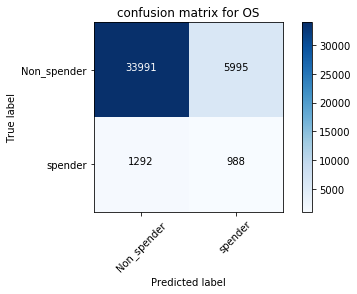

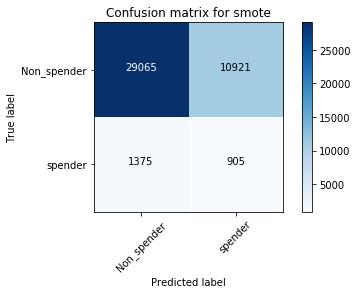

In [99]:
cnf_matrix = metrics.confusion_matrix(test_label, os_class)
cnf_matrix2 = metrics.confusion_matrix(test_label, smote_class)

plt.figure(1)
plot_confusion_matrix(cnf_matrix, classes=('Non_spender', 'spender'), title='confusion matrix for OS')
plt.figure(2)
plot_confusion_matrix(cnf_matrix2,classes=('Non_spender', 'spender'), title='Confusion matrix for smote')
plt.show();